In [1]:
import numpy as np
import matplotlib as mpl
from numpy import float32, float64
import matplotlib.pyplot as plt
from functools import partial
import itertools
from collections import namedtuple
import math
import scipy as sp
import pandas as pd
import matplotlib.animation as animation
from scipy.optimize import fsolve
import os

# Task 1

### New variables

$$
\begin{cases}
    x_1 = x \\
    x_2 = x' = x_1'\\
    x_3 = y \\
    x_4 = y' = x_3' \\
\end{cases}
$$

### System of first order differential equations

$$
\begin{cases}
    x_1' = x_2 \\
    x_2' = - \frac{x_1}{m L} T \\
    x_3' = x_4 \\
    x_4' = - \frac{x_3}{m L} T - \frac{F(t)}{m}
\end{cases}
$$

$$
\begin{aligned}
x_1^2 + x_3^2 = L^2 \to x_1 x_1' + x_3 x_3' = 0 \to (x_1')^2 + (x_3')^2 + x_1 x_1'' + x_3 x_3'' = 0 \\
x_1 x_2' + x_3 x_4' = - [(x_1')^2 + (x_3')^2] = - [x_2^2 + x_4^2] \\
x_1 x_2' + x_3 x_4' = - \frac{L T + y F(t)}{m} \\
x_2^2 + x_4^2 = \frac{L T + y F(t)}{m} \\
L T = m (x_2^2 + x_4^2) - yF(t) \\
\end{aligned}
$$

In [2]:
# https://perso.crans.org/besson/publis/notebooks/runge-kutta_methods_for_ODE_integration_in_Python.html
def rk4(fs: np.array, xs: np.array, t: float, step: float, **kwargs):
    def get_next_value(f, y):
        k_1 = f(xs, t, **kwargs)
        k_2 = f(xs + k_1 * step / 2.0, t + step / 2.0, **kwargs)
        k_3 = f(xs + k_2 * step / 2.0, t + step / 2.0, **kwargs)
        k_4 = f(xs + k_3 * step, t + step, **kwargs)
        return y + (step / 6.0) * (k_1 + 2.0 * k_2 + 2.0 * k_3 + k_4)

    return np.vectorize(get_next_value)(fs, xs)

In [3]:
def calculate_tension(xs: np.array, t, m: float, f, l, *args, **kwargs) -> float:
    return (m * (xs[1] ** 2.0 + xs[3] ** 2.0) - xs[2] * f(t, m)) / l


def f_1(xs: np.array, *args, **kwargs) -> float:
    return xs[1]


def f_2(xs: np.array, t, m, l, f, *args, **kwargs) -> float:
    tension = calculate_tension(xs, t, m, f, l)
    return -1.0 * xs[0] / (m * l) * tension


def f_3(xs: np.array, *args, **kwargs) -> float:
    return xs[3]


def f_4(xs: np.array, t, m, l, f, *args, **kwargs) -> float:
    tension = calculate_tension(xs, t, m, f, l)
    return -1.0 * xs[2] / (m * l) * tension - f(t, m) / m 

In [4]:
def j_1(xs: np.array, *args, **kwargs) -> np.array:
    return np.array([0.0, 1.0, 0.0, 0.0])


# https://www.wolframalpha.com/input?i2d=true&i=Partial%5BDivide%5B-Subscript%5Bx%2C1%5D%2Cm+l%5DDivide%5Bm%2Cl%5D%5C%2840%29power%5BSubscript%5Bx%2C2%5D%2C2%5D%2Bpower%5BSubscript%5Bx%2C4%5D%2C2%5D%5C%2841%29+%2B+Subscript%5Bx%2C3%5DDivide%5BSubscript%5Bx%2C1%5D%2Cm+l%5D+f%5C%2840%29t%5C%2841%29%2CSubscript%5Bx%2C1%5D%5D
def j_2(xs: np.array, t, m, l, f, *args, **kwargs) -> np.array:
    return np.array(
        [
            (l * xs[2] * f(t, m) - m * xs[2] ** 2.0) / (l**2.0 * m)
            - xs[3] ** 2.0 / l**2.0,
            -2.0 * xs[0] * xs[1] / l**2.0,
            xs[0] * f(t, m) / (l * m),
            -2.0 * xs[0] * xs[3] / l**2.0,
        ]
    )


def j_3(xs: np.array, *args, **kwargs) -> np.array:
    return np.array([0.0, 0.0, 0.0, 1.0])


def j_4(xs: np.array, t, m, l, *args, **kwargs) -> np.array:
    return np.array(
        [
            0.0 - 2.0 * xs[1] * xs[2] / l**2.0,
            (2 * l * xs[2] * f(t, m) - m * (xs[1] ** 2.0 + xs[3] ** 2.0))
            / (l**2.0 * m),
            -2.0 * xs[2] * xs[3] / l**2.0,
        ]
    )

In [5]:
 m = 2.0  # kg
l = 8.0  # m
g = lambda t: 0.01 * np.cos(2 * np.pi * t)  # additional force
f = lambda t, m: m * (9.81 + g(t))  # gravity
fs = np.array([f_1, f_2, f_3, f_4])  # right-hand side
js = np.array([j_1, j_2, j_3, j_4])  # jacobians for right-hand side
xs_0 = np.array([3.0, 0.0, -np.sqrt(55.0), 0.0])  # initial position
step = 0.001  # seconds

In [6]:
 t = 0.0  # initial time
t_b = 4.0  # upper bound on time
xs = xs_0  # initial conditions
solution = []
ts = []

while t <= t_b:
    xs = rk4(fs, xs, t, step, m=m, l=l, f=f)
    solution.append(xs)
    ts.append(t)
    t += step

x = np.array(list(map(lambda y: y[0], solution)))
y = np.array(list(map(lambda y: y[2], solution)))

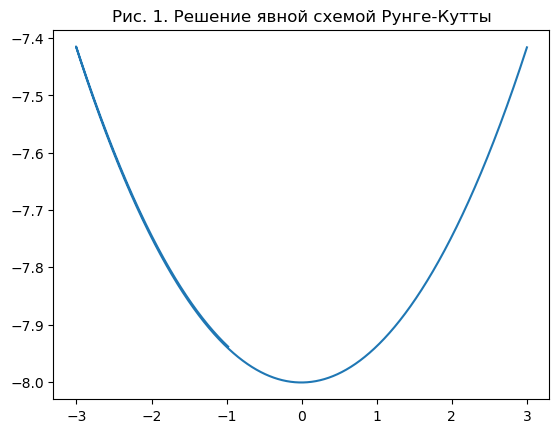

In [7]:
plt.figure()
plt.title("Рис. 1. Решение явной схемой Рунге-Кутты")
plt.plot(x, y)
plt.savefig("output/task1-explicit-rk4.pdf", transparent=False, bbox_inches="tight")
plt.show()

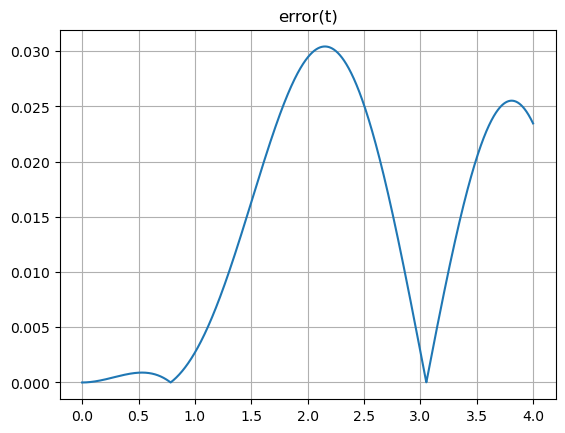

In [8]:
t = np.array(list(map(lambda y: y, ts)))
z = []
for i in range(len(x)):
    z.append(abs(l**2 - (x[i]**2+y[i]**2)))

plt.figure()
plt.plot(t, z)
plt.title("error(t)")
plt.grid()
plt.show()

In [9]:
def newton_solve(x0, f, jacob, eps: float, norm=np.inf, max_iter=1000000) -> np.array:
    cur = prev = x0

    for i in range(max_iter):
        j = jacob(*prev)
        inv_jacob = np.linalg.inv(j)
        delta = np.matmul(inv_jacob, f(*prev))
        cur -= delta
        err = np.linalg.norm(delta, norm)
        if err < eps:
            return cur

    raise runtimeWarning("Simple iteration does not converge or is slowly converging")

In [10]:
# Implementation of Explicit and Implicit runge-kutta methods to
# reduce the computational cost of pollutant transport modeling
# Ioannis Charis
# https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_method
def gl4(
    fs: np.array,
    js: np.array,
    xs: np.array,
    t: float,
    step: float,
    eps: float,
    max_iter: int = 10,
    **kwargs
):
    # Butcher table for Gauss–Legendre
    a11 = 0.25
    a12 = 0.25 - np.sqrt(3.0) / 6.0
    a21 = 0.25 + np.sqrt(3.0) / 6.0
    a22 = 0.25

    b1 = 0.5
    b2 = 0.5

    c1 = 0.5 - np.sqrt(3.0) / 6.0
    c2 = 0.5 + np.sqrt(3.0) / 6.0

    def get_next_value(f, j, y):
        k = f(xs, t, **kwargs)

        xs_1_guess = xs + c1 * step * k
        xs_2_guess = xs - c2 * step * k

        k_1_guess = f(xs_1_guess, t + c1 * step, **kwargs)
        k_2_guess = f(xs_2_guess, t + c2 * step, **kwargs)
        ks_0 = np.array([k_1_guess, k_2_guess])

        def f_for_k(k_1_cur, k_2_cur):
            return step * np.array(
                [
                    k_1_cur
                    - f(
                        xs + (k_1_cur * a11 + k_2_cur * a12) * step,
                        t + c1 * step,
                        **kwargs
                    ),
                    k_2_cur
                    - f(
                        xs + (k_1_cur * a21 + k_2_cur * a22) * step,
                        t + c2 * step,
                        **kwargs
                    ),
                ]
            )

        def j_for_k(k_1_cur, k_2_cur):
            j1 = j(xs + (k_1_cur * a11 + k_2_cur * a12) * step, t + c1 * step, **kwargs)
            j2 = j(xs + (k_1_cur * a12 + k_2_cur * a22) * step, t + c2 * step, **kwargs)

            return np.eye(2) - step * np.array(
                [
                    [a11 * np.sum(j1), a12 * np.sum(j1)],
                    [a21 * np.sum(j2), a22 * np.sum(j2)],
                ]
            )

        ks = newton_solve(ks_0, f_for_k, j_for_k, eps=eps, max_iter=max_iter)
        k_1, k_2 = ks
        return y + step * (b1 * k_1 + b2 * k_2)

    return np.vectorize(get_next_value)(fs, js, xs)

In [11]:
step = 0.005  # seconds
t = 0.0  # initial time
t_b = 4.0  # upper bound on time
xs = xs_0  # initial conditions
solution = []

while t <= t_b:
    xs = gl4(fs, js, xs, t, step, 1e-4, 1000, m=m, l=l, f=f)
    solution.append(xs)
    t += step

x = np.array(list(map(lambda y: y[0], solution)))
y = np.array(list(map(lambda y: y[2], solution)))

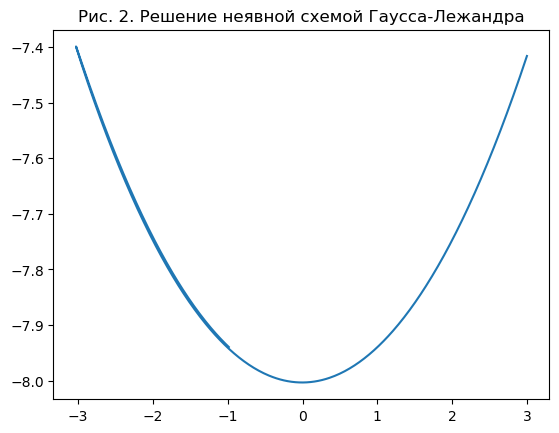

In [12]:
plt.figure()
plt.title("Рис. 2. Решение неявной схемой Гаусса-Лежандра")
plt.plot(x, y)
plt.savefig("output/task1-implicit-gl4.pdf", transparent=False, bbox_inches="tight")
plt.show()

# Task 2

### New variables:
$$\frac{dx}{dt} = v_x$$
$$m \frac{dv_x}{dt} = 2 v_y + x + \frac{\gamma (x - \mu r1. x)}{r_1^3} + \frac{\mu (x - \gamma r2. x)}{r_2^3} - f v_x$$
$$\frac{dy}{dt} = v_y$$
$$\frac{dv_y}{dt} = -2 v_x + y + \frac{\gamma (y - r1. y)}{r_1^3} + \frac{\mu (y - r2. y)}{r_2^3} - f v_y$$

$$\mu = 0.00095388$$
$$\gamma = 1 - \mu$$
$$r_1^2 = (x - \mu r1. x)^2 + (y - r1.y)^2$$
$$r_2^2 = (x - \gamma r2. x)^2 + (y - r2.y)^2$$

In [13]:
mu = 0.00095388
gamma = 1 - mu
epsilon = 1e-5
f = 0.1
r1 = [0.5 - 0.5 * mu, -0.5 * math.sqrt(3)]
r2 = [0.5 * math.sqrt(3), 0.5 - 0.5 * mu]
delta_t = 0.08
start = 0
stop = 7


def get_dist_1(x : float, y : float):
    Coordx = x - r1[0] * mu
    Coordy = y - r1[1]
    return math.sqrt(Coordx**2 + Coordy**2)

def get_dist_2(x : float, y : float):
    Coordx = x - r2[0] * gamma
    Coordy = y - r2[1]
    return math.sqrt(Coordx**2 + Coordy**2)
    

def get_derivative(u : list) -> list:
    t, x, vx, y, vy = u
    
    Derrvx = 2 * vy + x + gamma * (x - mu * r1[0]) / get_dist_1(x, y)**3 + mu * (x - gamma * r2[0]) / get_dist_2(x, y)**3 - f * vx
    Derrvy = -2 * vx + y + gamma * (y - r1[1])  / get_dist_1(x, y)**3 + mu * (y - r2[1]) / get_dist_2(x, y)**3 - f * vy
    Deriv = np.array([1, vx, Derrvx, vy, Derrvy])
    return Deriv

def get_start_coord() -> list:
    return np.array([0, 0, 0, 0, 0])

      
def calculate_adams_trajectory(start_coord : list, start: float, stop: float, delta_t: float) -> list:
    trajectory = []
    k0 = start_coord
    k1 = start_coord
    k2 = start_coord
    Numpoints = int((stop - start) / delta_t)
    for point in range(Numpoints):
        f2 = get_derivative(k2)
        f1 = get_derivative(k1)
        f0 = get_derivative(k0)
        k3 = k2 + delta_t * (23.0/12 * f2 - 16.0/12 * f1 + 5.0/12 * f0)
        trajectory.append(k2)
        k0 = k1
        k1 = k2
        k2 = k3
    return trajectory

def show_trajectory(args : list, vals : list, Title : str):
    plt.figure(figsize = (15, 8))
    plt.title(Title)

    x = []
    y = []
    for val in vals:
        x.append(val[1])
        y.append(val[3])
    if (len(args) > len(x)):
        args = np.delete(args, 0, 0)
    plt.plot(args, x, 'c', label = "x")
    plt.plot(args, y, 'm', label = "у")
    
    plt.legend()
    plt.grid()
    plt.show()  

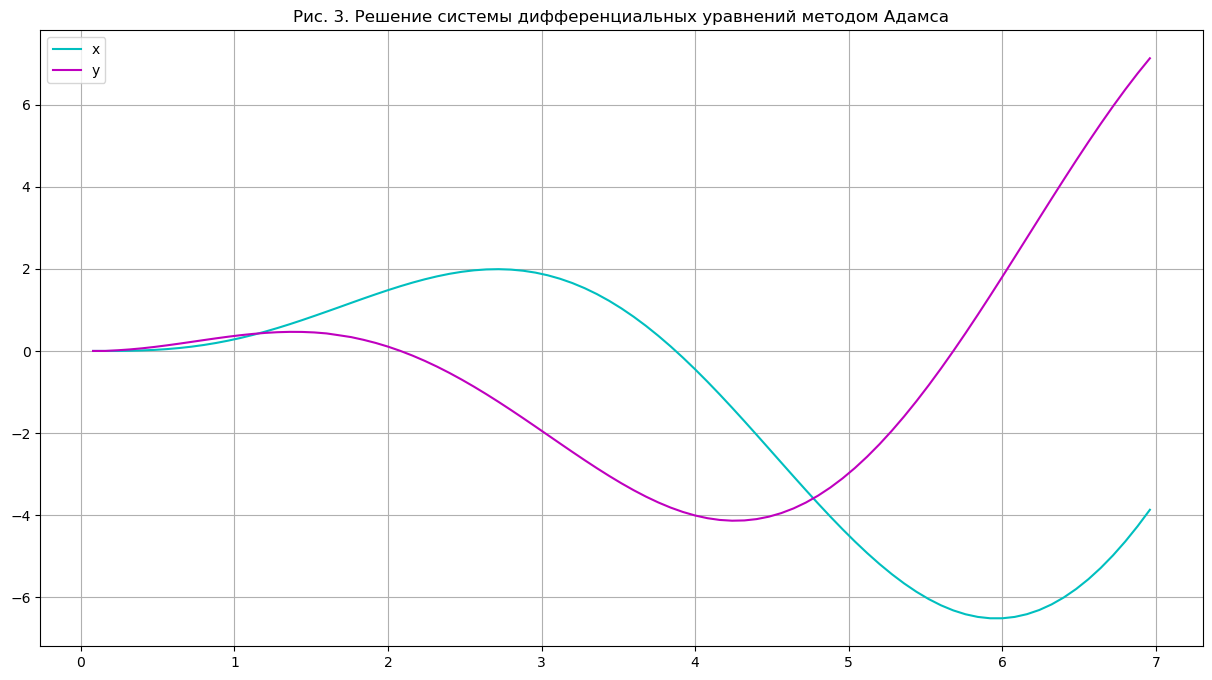

In [14]:
args = np.arange(start, stop, delta_t)
adams_vals = calculate_adams_trajectory(get_start_coord(), start, stop, delta_t)
show_trajectory(args, adams_vals, "Рис. 3. Решение системы дифференциальных уравнений методом Адамса")

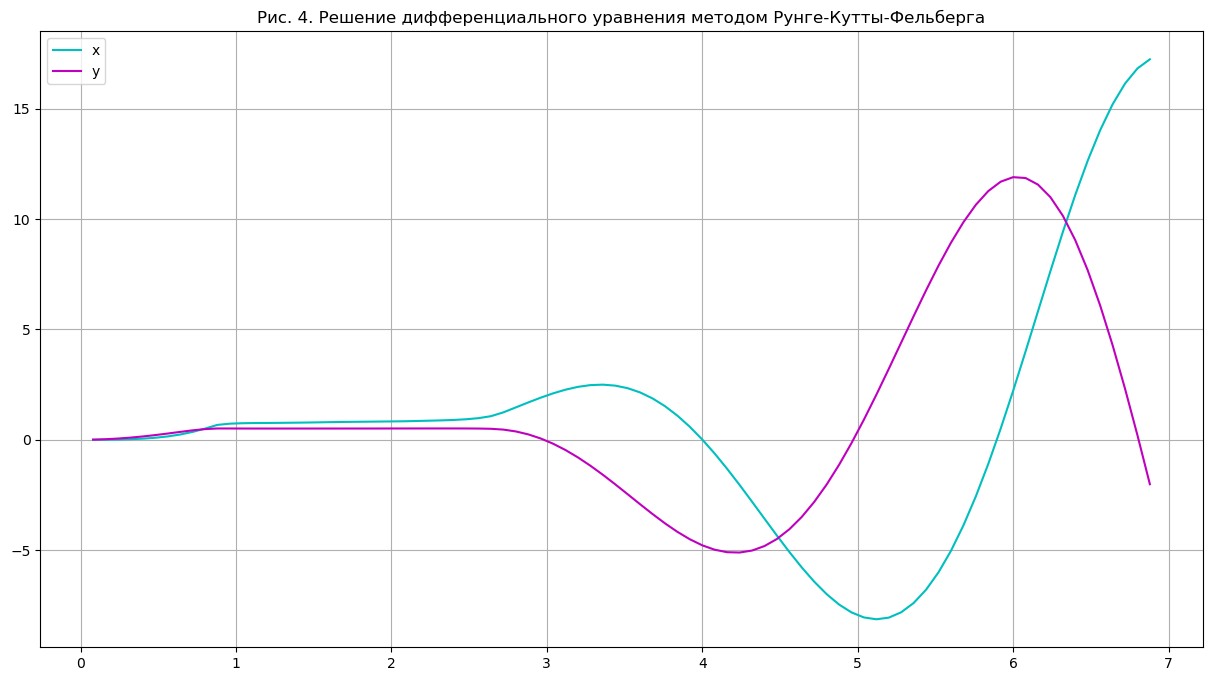

In [15]:
def get_norm(U : list):
    t, x, vx, y, vy = U
    return math.sqrt(x**2 + vx**2 + y**2 + vy**2)

def calculate_runge_kutta_trajectory(start_coord : list, start: float, stop: float, delta_t: float) -> list:
    trajectory = []
    U0 = start_coord
    Numpoints = int((stop - start) / delta_t - 1)
    for point in range(Numpoints):
        k1 = get_derivative(U0)
        k2 = get_derivative(U0 + delta_t / 4 * k1)
        point3 = U0 + 3 * delta_t / 32 * k1 + 9 * delta_t / 32 * k2
        point3[0] = U0[0] + 3 * delta_t / 8
        k3 = get_derivative(point3)
        point4 = U0 + 1932 * delta_t / 2197 * k1 - 7200 * delta_t / 2197 * k2 + 7296 * delta_t / 2197 * k3
        point4[0] = U0[0] + 12 * delta_t / 13
        k4 = get_derivative(point4)
        point5 = U0 + 439 * delta_t / 216 * k1 - 8 * delta_t * k2 + 3680 * delta_t / 513 * k3 - 845 * delta_t / 4104 * k4
        point5[0] = U0[0] + delta_t
        k5 = get_derivative(point5)
        point6 = U0 - 8 * delta_t / 27 * k1 + 2 * delta_t * k2 - 3544 * delta_t / 2565 * k3 + 1859 * delta_t / 4104 * k4 - 11 * delta_t / 40 * k5
        point6[0] = U0[0] + delta_t / 2
        k6 = get_derivative(point6)
        
        U1 = U0 + delta_t * (25 * k1 / 216 + 1408 * k3 / 2565 + 2197 * k4 / 4104 - k5 / 5)
        U2 = U0 + delta_t * (16 * k1 / 135 + 6656 * k3 / 12825 + 28561 * k4 / 56430 - 9 * k5 / 50 + 2 * k6 / 55)
        
        delta_opt = delta_t * (epsilon * delta_t / (2 * get_norm(U1 - U2)))**(1.0 / 4)
        
        U1 = U0 + delta_opt * (25 * k1 / 216 + 1408 * k3 / 2565 + 2197 * k4 / 4104 - k5 / 5)
        U0 = U1
        trajectory.append(U0)
    return trajectory

args = np.arange(start, stop - delta_t, delta_t)
runge_kutta_vals = calculate_runge_kutta_trajectory(get_start_coord(), start, stop, delta_t)
show_trajectory(args, runge_kutta_vals, "Рис. 4. Решение дифференциального уравнения методом Рунге-Кутты-Фельберга")

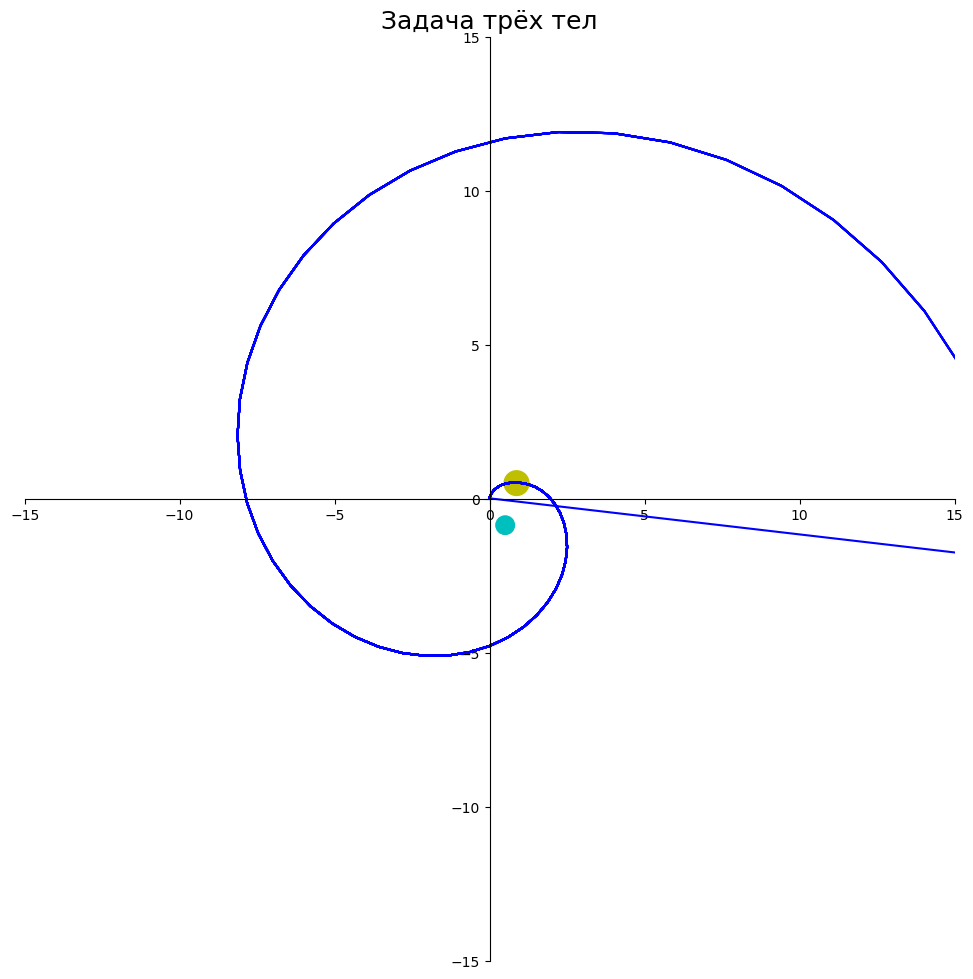

In [16]:
x_coord = []
y_coord = []

def animate(i):
    x_coord.append(df['x'].iloc[i])
    y_coord.append(df['y'].iloc[i])
    ax.plot(x_coord,y_coord, 'b')

df = pd.DataFrame()
args = np.arange(start, stop, delta_t)
adams_vals = calculate_runge_kutta_trajectory(get_start_coord(), start, stop, delta_t)
x = []
y = []
for val in adams_vals:
    x.append(val[1])
    y.append(val[3])
df['x'] = x
df['y'] = y
df.head()
path_script = os.getcwd()
df.to_csv(path_script + '/dataset.csv', index = False)

df = pd.DataFrame()
path_script = os.getcwd()
df = pd.read_csv(path_script + '/dataset.csv')

fig,ax = plt.subplots(figsize = (12,12))

Lim = 15
ax.set_xlim(-Lim, Lim)
ax.set_ylim(-Lim, Lim)

ax.set_title('Задача трёх тел', fontsize = 18)

yupiter = plt.Circle((r1[0], r1[1]), 0.3, color='c', fill=True)
Sun = plt.Circle((r2[0], r2[1]), 0.4, color='y', fill=True)
    
ax = plt.gca()
    
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))

ax.add_patch(yupiter)
ax.add_patch(Sun)

anim = animation.FuncAnimation(fig, animate,  frames = len(df.index), interval = len(df.index))
anim.save(os.getcwd() + '/output/three_bodies.gif', fps = 10, writer = 'pillow')

# Task 3

### New variables

$$
\begin{cases}
    u = y \\
    v = y' \\
\end{cases}
$$

### System of first order differential equations

$$
\begin{cases}
    u' = v \\
    v' = (3 - t^2) (cos(t) + v) + 2 - 6 t + 2 t^3 + (t^2 - 3) e^t sin(t) (1 + cos(t)) + cos(t) (e^t + (t^2 - 1) + t^4 - 3t^2)
\end{cases}
$$

$$
\begin{cases}
    u(0) = 0 \\
    u(\pi) = \pi^2
\end{cases}
$$

In [17]:
u_0 = 0.0

In [18]:
def f(xs, t):
    u, v = xs
    return v

def g(xs, t):
    u, v = xs
    return (
        (3.0 - t**2.0) * (np.cos(t) + v)
        + 2.0
        - 6.0 * t
        + 2.0 * t**3.0
        + (t**2.0 - 3.0) * np.exp(t) * np.sin(t) * (1.0 + np.cos(t))
        + np.cos(t) * (np.exp(t) + (t**2.0 - 1.0) + t**4.0 - 3.0 * t**2.0)
    )

In [19]:
def get_next_value_rk4(f, y: float, xs: np.array, t: float, step: float):
    k_1 = f(xs, t)
    k_2 = f(xs + k_1 * step / 2.0, t + step / 2.0)
    k_3 = f(xs + k_2 * step / 2.0, t + step / 2.0)
    k_4 = f(xs + k_3 * step, t + step)
    return y + (step / 6.0) * (k_1 + 2.0 * k_2 + 2.0 * k_3 + k_4)

# https://perso.crans.org/besson/publis/notebooks/runge-kutta_methods_for_ODE_integration_in_Python.html
def rk4(f, x: float, xs: np.array, t: float, step: float):
    return get_next_value_rk4(f, x, xs, t, step)

In [20]:
def solve_initial_value_problem(xs_0: np.array, step: float = 0.001):
    global f
    global g

    t = 0.0  # initial time
    t_b = np.pi  # upper bound on time
    xs = xs_0  # initial conditions
    solution = []

    while t <= t_b:
        u, v = xs
        xs = np.array([rk4(f, u, xs, t, step), rk4(g, v, xs, t, step)])
        solution.append(np.array([*xs, t]))
        t += step

    return np.array(solution).transpose()

In [21]:
# https://pythonnumericalmethods.berkeley.edu/notebooks/chapter23.02-The-Shooting-Method.html
def objective(v_0, step: float = 0.001):
    us, vs, _ = solve_initial_value_problem(np.array([u_0, *v_0]), step)
    expected_u = np.pi**2.0
    return us[-1] - expected_u

In [22]:
(v_0,) = fsolve(objective, 0.0)
us, vs, ts = solve_initial_value_problem(np.array([u_0, v_0]))

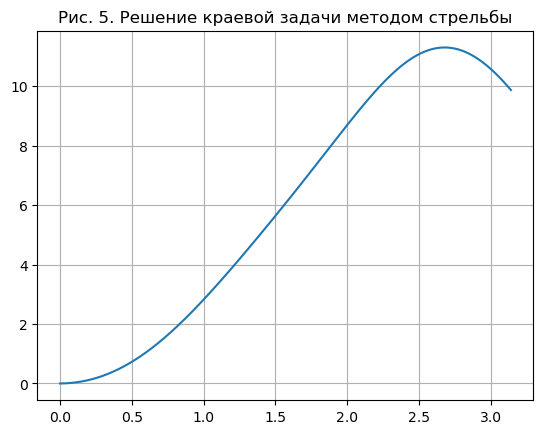

In [23]:
plt.figure()
plt.title("Рис. 5. Решение краевой задачи методом стрельбы")
plt.plot(ts, us)
plt.grid()
plt.savefig("output/task3-shooting.pdf", transparent=False, bbox_inches="tight")
plt.show()